In [1]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Lambda, Dense, Flatten
from keras.layers import Activation, MaxPooling2D, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, LearningRateScheduler,ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob,os
import seaborn as sns
from keras.regularizers import l2
from math import ceil
from keras.datasets import cifar10, mnist
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend.tensorflow_backend import set_session
from keras.applications.resnet50 import ResNet50
import seaborn as sns

Using TensorFlow backend.


In [2]:
batch_size = 4
input_shape = (500,500,3)
resume = False
epochs=20
init=0

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [4]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=True,
                                    zca_epsilon=1e-06,
                                    rotation_range=180,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    channel_shift_range=0.,
                                    fill_mode='nearest',
                                    cval=0.,
                                    vertical_flip=True,
                                    preprocessing_function=None,
                                    data_format=None)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('./data/train',
                                                    target_size=(500,500),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('./data/validation',
                                                        target_size=(500,500),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 4195 images belonging to 6 classes.
Found 739 images belonging to 6 classes.


In [5]:
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
# keras.applications.xception.Xception(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
# model = keras.applications.resnet50.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
# model= keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
# keras.applications.mobilenet.MobileNet(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
#model = keras.applications.xception.Xception(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=6)
modelName = "InceptionResNetv2"
save_dir = os.path.join(os.getcwd(), 'checkpoint')
model_name = modelName+'_{epoch:03d}.h5'

In [7]:
if resume:
    tmp_path = "./checkpoint"
    model = load_model(tmp_path)

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer="adam",
                metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 249, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 249, 249, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 249, 249, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 14, 14, 256)  172032      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, 14, 14, 192)  576         conv2d_172[0][0]                 
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, 14, 14, 256)  768         conv2d_175[0][0]                 
__________________________________________________________________________________________________
activation_172 (Activation)     (None, 14, 14, 192)  0           batch_normalization_172[0][0]    
__________________________________________________________________________________________________
activation_175 (Activation)     (None, 14, 14, 256)  0           batch_normalization_175[0][0]    
__________

In [8]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [9]:
filepath = os.path.join(save_dir, model_name)

cpt = ModelCheckpoint(filepath = filepath, 
                            monitor ='val_acc',
                            verbose = 1,
                            save_best_only = True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = np.sqrt(0.1),
                               cooldown=0,
                               patience = 5,
                               min_lr = 0.5e-8)

In [10]:
tb = TensorBoard(log_dir='./logs', histogram_freq=0,
                batch_size=batch_size, 
                write_graph=True, write_grads=False, 
                write_images=False, embeddings_freq=0, 
                embeddings_layer_names=None, 
                embeddings_metadata=None) 

cbs = [cpt, lr_reducer, lr_scheduler, tb]

In [11]:
history = model.fit_generator(train_generator,
                        validation_data=validation_generator,
                        epochs = epochs, 
                        verbose = 1, 
                        workers = 1, 
                        shuffle = True,
                        callbacks = cbs,
                        steps_per_epoch = 30000,
                        samples_per_epoch=2000,
                        validation_steps = 100,
                        initial_epoch=init)

/home/dongpeijie/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=20, verbose=1, workers=1, shuffle=True, callbacks=[<keras.ca..., steps_per_epoch=500, validation_steps=100, initial_epoch=0)`
  # This is added back by InteractiveShellApp.init_path()


Learning rate:  0.0001


/home/dongpeijie/miniconda3/envs/keras/lib/python3.6/site-packages/keras/preprocessing/image.py:554: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
1049/500 [==============================================================] - 765s 729ms/step - loss: 0.9637 - acc: 0.6488 - val_loss: 0.8054 - val_acc: 0.7442
Learning rate:  0.0001
Epoch 2/20
1049/500 [==============================================================] - 653s 623ms/step - loss: 0.6576 - acc: 0.7671 - val_loss: 0.6755 - val_acc: 0.7659
Learning rate:  0.0001
Epoch 3/20
1049/500 [==============================================================] - 656s 625ms/step - loss: 0.5974 - acc: 0.7951 - val_loss: 0.6553 - val_acc: 0.8011
Learning rate:  0.0001
Epoch 4/20
1049/500 [==============================================================] - 661s 630ms/step - loss: 0.4827 - acc: 0.8350 - val_loss: 0.4607 - val_acc: 0.8850
Learning rate:  0.0001
Epoch 5/20
1049/500 [==============================================================] - 660s 629ms/step - loss: 0.3939 - acc: 0.8736 - val_loss: 0.2803 - val_acc: 0.9229
Learning rate:  0.0001
Epoch 6/20
1049/500 [===================

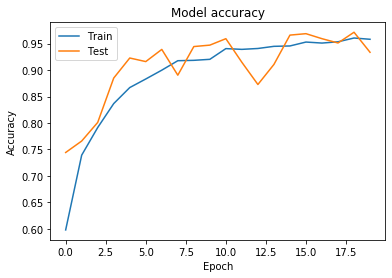

In [12]:
plt.figure()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

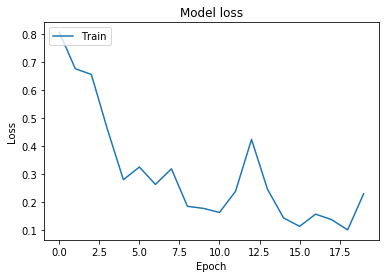

In [13]:
plt.figure()
# 绘制训练 & 验证的损失�?plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()